In [1]:
import pandas as pd
import requests
import json
import dml
import prov.model
import datetime
import uuid
import csv 
from io import StringIO
import json
import pymongo
import numpy as np

import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans

In [2]:
contributor = 'mmao95_Dongyihe_weijiang_zhukk'
reads = [contributor + '.streetbook_filtered']
writes = [contributor + '.street_clustered_location']

In [3]:
startTime = datetime.datetime.now()

# Set up the database connection.
client = dml.pymongo.MongoClient()
repo = client.repo
repo.authenticate(contributor, contributor)

True

In [4]:
streetbook_filtered_list = list(repo[reads[0]].find())
streetbook_filtered_df = pd.DataFrame(streetbook_filtered_list)
streetbook_filtered_list = np.array(streetbook_filtered_df).tolist()

street_lat_long = pd.read_csv("http://datamechanics.io/data/roads_2013_jzi.csv").values.tolist()

In [5]:
print(streetbook_filtered_list[0])
print(street_lat_long[0])

['Abbotsford Street,', 'Abbotsford', '02121', ObjectId('5cbb8e361877df585c0f8949')]
['roads_2013_jzi.1', 'MULTILINESTRING ((-71.158407 42.260028, -71.158463 42.260158))', 25, 25, 85728971, 205866436, 205862089, 'S1400', 'Stimson St', 2758.0, nan, nan, nan, nan, nan, nan, 15.16, 5, 5, 0, 0, 'None', 250251304043.0, 25025130404.0]


In [6]:
# process street latitude and longitude dataset
street_lat_long_data = [(fullName, location, length) for (fId, location, s, c, tl, tf, tf2, m, fullName,
                                                    sm, lf, lt, rf, rt, zi, zipr, length, classGroup, r,
                                                    cluster, m, zone, bg, ct) in street_lat_long]

# print(street_lat_long[0])
lat_long_df = pd.DataFrame(street_lat_long_data)
lat_long_df.columns = ['fullName', 'location', 'length']
lat_long_df = lat_long_df.dropna()

In [7]:
lat_long_list = np.array(lat_long_df).tolist()
print(lat_long_list[0])

['Stimson St', 'MULTILINESTRING ((-71.158407 42.260028, -71.158463 42.260158))', 15.16]


In [8]:
# normalize latitude and longitude list
for i in range(0, len(lat_long_list)):
    lat_long_list[i][1] = lat_long_list[i][1][18 : -2]

for i in range(0, len(lat_long_list)):
    pairs = lat_long_list[i][1].split(',')
    for j in range(0, len(pairs)):
        pairs[j] = pairs[j].lstrip()
    
    pair_tuple = []
    for j in range(0, len(pairs)):
        str = pairs[j].split(' ')
        pair_tuple.append([float(str[0]), float(str[1])])
    lat_long_list[i][1] = pair_tuple

print(len(lat_long_list))

20233


In [9]:
# aggregate same street name
def aggregate(R, f):
    keys = {r[0] for r in R}
    return [(key, f([v for (k,v) in R if k == key])) for key in keys]

In [10]:
# lat_long_list = [(fullName, (location, length)) for (fullName, location, length) in lat_long_list]
name_unique = np.array(lat_long_df['fullName'].unique()).tolist()
street_agg_list = [[fullName, [], 0] for fullName in name_unique]
print(type(street_agg_list[0][1]))
print(type(lat_long_list[0][1]))
for i in range(0, len(street_agg_list)):
    for j in range(0, len(lat_long_list)):
        if(street_agg_list[i][0] == lat_long_list[j][0]):
            street_agg_list[i][1].extend(lat_long_list[j][1])
            street_agg_list[i][2] += lat_long_list[j][2]
            
print(street_agg_list[4])

<class 'list'>
<class 'list'>
['Weymouth Ave', [[-71.151772, 42.266096], [-71.151862, 42.266202], [-71.15186199999998, 42.266201999999986], [-71.15228499999999, 42.266504999999995], [-71.15292599999998, 42.267053999999995], [-71.153097, 42.26720799999999]], 165.29]


In [11]:
# process datasets for K means
output_street_location = []
for i in range(0, len(street_agg_list)):
    count1 = 0
    count2 = 0
    for j in range(0, len(street_agg_list[i][1])):
        count1 += street_agg_list[i][1][j][0]
        count2 += street_agg_list[i][1][j][1]
    output_street_location += [[street_agg_list[i][0], count1 / len(street_agg_list[i][1]), count2 / len(street_agg_list[i][1]), street_agg_list[i][2]]]
print(len(output_street_location))

4567


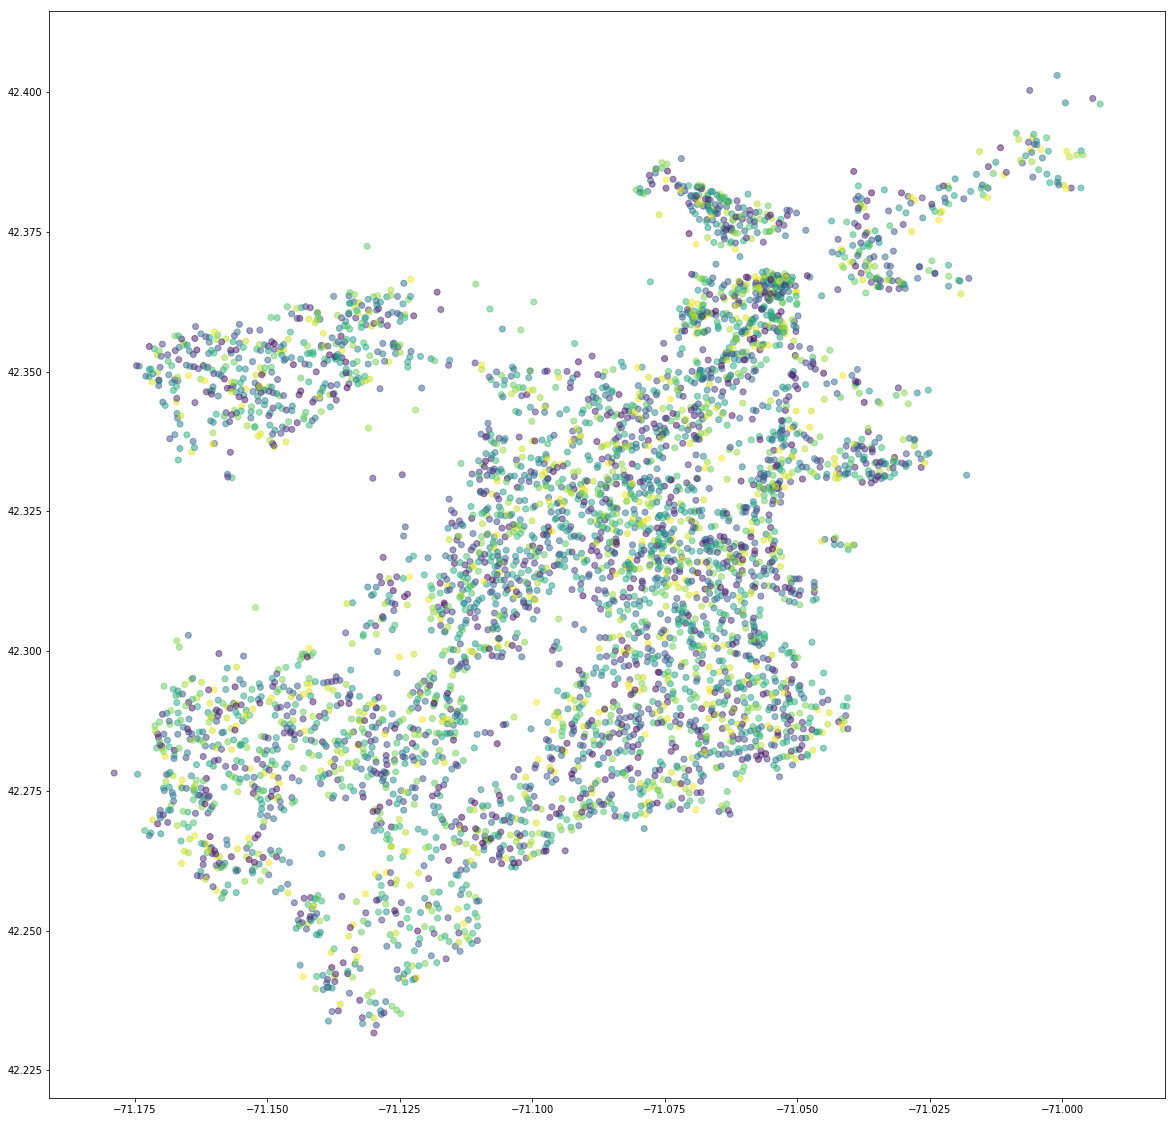

In [12]:
long_lat_list = [(long, lat) for (fullName, long, lat, length) in output_street_location]
long_lat_df = pd.DataFrame(long_lat_list)
long_lat_df.columns = ['long', 'lat']
x = long_lat_df['long']
y = long_lat_df['lat']
colors = np.random.rand(len(long_lat_df))
plt.figure(figsize=(20,20))
plt.scatter(x, y,c = colors, alpha = 0.5)
plt.show()

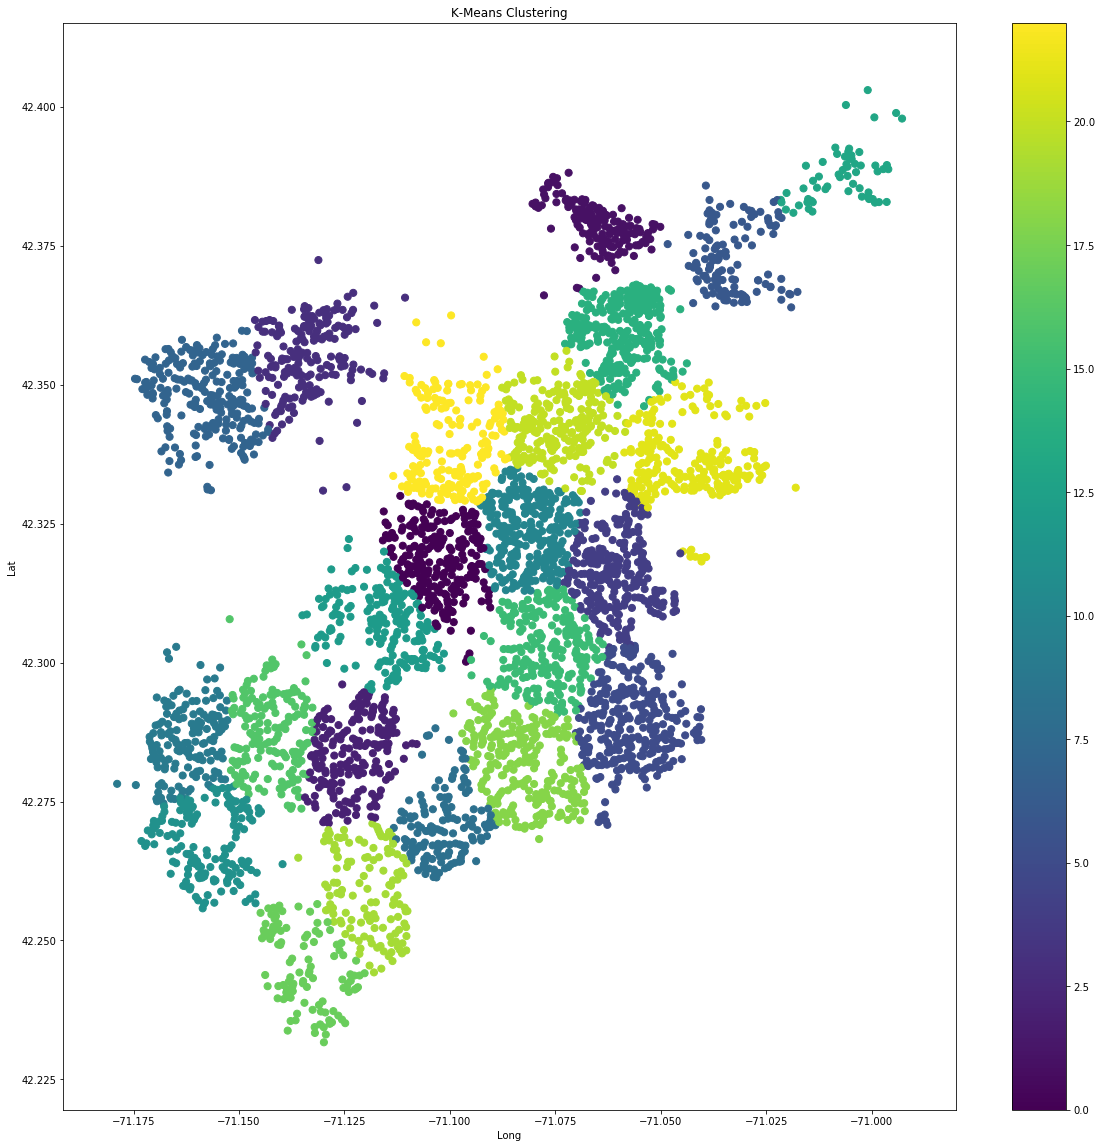

In [13]:
# set datasets into 34 clusters
X = long_lat_df
X = X[~np.isnan(X)]

#K means Clustering 
def doKmeans(X, nclust):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

clust_labels, cent = doKmeans(X, 23)
kmeans = pd.DataFrame(clust_labels)
X.insert((X.shape[1]),'kmeans',kmeans)

#Plot the clusters obtained using k means
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
scatter = ax.scatter(X['long'],X['lat'],
                     c = kmeans[0],s = 50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('Long')
ax.set_ylabel('Lat')
plt.colorbar(scatter)

In [14]:
kmeans_list = np.array(kmeans).tolist()
for i in range(0, len(output_street_location)):
    output_street_location[i] += (kmeans_list[i])

print(output_street_location)

[['Stimson St', -71.16210674358973, 42.261810846153836, 992.73, 11], ['Grove St', -71.14318346969696, 42.27903903030301, 1704.0800000000002, 16], ['Washington St', -71.10704185440608, 42.309478670498066, 26210.980000000003, 12], ['Rockingham Ave', -71.15560211764705, 42.264634764705875, 312.82, 11], ['Weymouth Ave', -71.15230066666666, 42.266544499999995, 165.29, 11], ['Vershire St', -71.14684733333333, 42.2715701111111, 201.7, 11], ['Cowing St', -71.14794948, 42.2738862, 616.0899999999999, 11], ['Buchanan Rd', -71.13697786206896, 42.29539620689655, 601.33, 16], ['Centre St', -71.12502912400633, 42.298888465818784, 14643.889999999998, 12], ['Starbird Ave', -71.11480442857143, 42.28472528571428, 263.24, 2], ['Neponset Ave', -71.06856199999997, 42.283470074829914, 3973.0900000000006, 5], ['Canterbury St', -71.11038266911767, 42.2851104632353, 3395.15, 2], ['American Legion Hwy', -71.10496155502388, 42.286906392344505, 7878.700000000001, 8], ['Jalleison St', -71.1166894, 42.27605039999999

In [15]:
print(len(output_street_location))
print(output_street_location[4])

4567
['Weymouth Ave', -71.15230066666666, 42.266544499999995, 165.29, 11]


In [16]:
street_clustered = [[cluster, fullName] for (fullName, long, lat, length, cluster) in output_street_location]
later_use = street_clustered
street_clustered = [[cluster, name] for (cluster, fullName1) in street_clustered 
                    for (fullName2, name, zipcode, id) in streetbook_filtered_list if fullName2.startswith(fullName1)]

# print(street_clustered)
# print(len(street_clustered))

result = [[i, ] for i in range(0, 23)]
for i in range(0, 23):
    for j in range(0, len(street_clustered)):
        if(i == street_clustered[j][0]):
            result[i] += [street_clustered[j][1]]

# print(result[0])
# print(len(result[0]))

# for i in range(0, 23):
#     str = ""
#     for j in range(1, len(result[i])):
#         str += result[i][j] + ","
#     result[i] = [i, str]
print(result)
print(len(result))

[[0, 'Perkins', 'Perkins', 'Sigourney', 'Dixwell', 'Brookledge', 'Oakdale', 'Oakdale', 'Amory', 'Day', 'Marcella', 'Mulvey', 'Eugene', 'Ellingwood', 'Bynner', 'Estey', 'Ashcroft', 'Moraine', 'Robinwood', 'Paul', 'Lawn', 'Wyman', 'Priesing', 'Cobden', 'Bromley', 'Roys', 'Atherton', 'Vale', 'Brinton', 'Brookside', 'Granada', 'Merriam', 'Bragdon', 'Mendell', 'Weld', 'Cleaves', 'Ruthven', 'Ruthven', 'Abbotsford', 'Lawndale', 'Zamora', 'Kingsboro', 'Nira', 'Biltmore', 'Lamartine', 'Belmore', 'Walden', 'Bolster', 'Enfield', 'Buckley', 'Dimock', 'Ritchie', 'Miles', 'Ernst', 'Valentine', 'Egleston', 'Rockview', 'Ophir', 'Dalrymple', 'Germania', 'Schiller', 'Parkwood', 'Goldsmith', 'Adelaide', 'Cranston', 'Sheridan', 'Castleton', 'Clive', 'Wensley', 'Bucknam', 'Creighton', 'Westerly', 'Sheridan', 'Forbes', 'Wise', 'Slayton', 'Atherton', 'Fort', 'Fort', 'Fort', 'Minton', 'Marmion', 'Glade', 'Eileen', 'Hilton', 'Kenney', 'Bickford', 'Paul', 'Hoffman', 'Segel', 'Ackley', 'Craftson', 'Locksley', 'M

In [17]:
# generate csv file
# street_agg_list
street_agg_df = pd.DataFrame(street_agg_list)
street_agg_df.columns = ['Full Name', 'Longitude and Latitude', 'Street Length']
street_agg_df.to_csv("/Users/zjallenjiang/Documents/GitHub/street_agg.csv")
# output_street_location
output_street_location_df = pd.DataFrame(output_street_location)
output_street_location_df.columns = ['Full Name', 'Longitude', 'Latitude', 'Street Length', 'Cluster']
output_street_location_df.to_csv("/Users/zjallenjiang/Documents/GitHub/street_location.csv")
# result
result_df = pd.DataFrame(result) 
result_df.to_csv("/Users/zjallenjiang/Documents/GitHub/street_clustered.csv")
result_df.to_json(path_or_buf = "/Users/zjallenjiang/Documents/GitHub/street_clustered.json", orient="records")

In [18]:
data = json.loads(output_street_location_df.to_json(orient="records"))
repo.dropCollection('street_clustered_location')
repo.createCollection('street_clustered_location')
repo[writes[0]].insert_many(data)

In [19]:
repo[writes[0]].metadata({'complete': True})
print(repo[writes[0]].metadata())
[record for record in repo[writes[0]].find()]

{'_id': ObjectId('5cc532991877df86d624953e'), 'complete': True}


[{'_id': ObjectId('5cc532981877df86d6248367'),
  'Full Name': 'Stimson St',
  'Longitude': -71.1621067436,
  'Latitude': 42.2618108462,
  'Street Length': 992.73,
  'Cluster': 11},
 {'_id': ObjectId('5cc532981877df86d6248368'),
  'Full Name': 'Grove St',
  'Longitude': -71.1431834697,
  'Latitude': 42.2790390303,
  'Street Length': 1704.08,
  'Cluster': 16},
 {'_id': ObjectId('5cc532981877df86d6248369'),
  'Full Name': 'Washington St',
  'Longitude': -71.1070418544,
  'Latitude': 42.3094786705,
  'Street Length': 26210.98,
  'Cluster': 12},
 {'_id': ObjectId('5cc532981877df86d624836a'),
  'Full Name': 'Rockingham Ave',
  'Longitude': -71.1556021176,
  'Latitude': 42.2646347647,
  'Street Length': 312.82,
  'Cluster': 11},
 {'_id': ObjectId('5cc532981877df86d624836b'),
  'Full Name': 'Weymouth Ave',
  'Longitude': -71.1523006667,
  'Latitude': 42.2665445,
  'Street Length': 165.29,
  'Cluster': 11},
 {'_id': ObjectId('5cc532981877df86d624836c'),
  'Full Name': 'Vershire St',
  'Longitud

In [20]:
repo.logout()
endTime = datetime.datetime.now()
{"start":startTime, "end":endTime}

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Database.logout() is deprecated
  """Entry point for launching an IPython kernel.


{'start': datetime.datetime(2019, 4, 28, 0, 56, 36, 460736),
 'end': datetime.datetime(2019, 4, 28, 0, 56, 57, 161042)}

In [21]:
# doc = prov.model.ProvDocument()
# startTime = None
# endTime = None
# client = dml.pymongo.MongoClient()
# repo = client.repo
# repo.authenticate(contributor, contributor)

# doc.add_namespace('alg', 'http://datamechanics.io/algorithm/') # The scripts are in <folder>#<filename> format.
# doc.add_namespace('dat', 'http://datamechanics.io/data/') # The data sets are in <user>#<collection> format.
# doc.add_namespace('ont', 'http://datamechanics.io/ontology#') # 'Extension', 'DataResource', 'DataSet', 'Retrieval', 'Query', or 'Computation'.
# doc.add_namespace('log', 'http://datamechanics.io/log/') # The event log.
# doc.add_namespace('bdp', 'https://www.50states.com/bio/mass.htm')

# this_script = doc.agent('alg:'+contributor+'#filtered_famous_people_streets', {prov.model.PROV_TYPE:prov.model.PROV['SoftwareAgent'], 'ont:Extension':'py'})
# res_fp = doc.entity('bdp:fp', {'prov:label':'Famous People in MA', prov.model.PROV_TYPE:'ont:DataResource', 'ont:Extension':'json'})
# res_sb = doc.entity('bdp:sb', {'prov:label':'Street Book', prov.model.PROV_TYPE:'ont:DataResource', 'ont:Extension':'json'})
# filter_names = doc.activity('log:uuid'+str(uuid.uuid4()), startTime, endTime)
# doc.wasAssociatedWith(filter_names, this_script)
# doc.usage(filter_names, res_fp, startTime, None,
#     {prov.model.PROV_TYPE: 'ont:Computation',
#     'ont:Computation':'Selection, Differentiate'
#     }
# )
# doc.usage(filter_names, res_sb, startTime, None,
#     {prov.model.PROV_TYPE: 'ont:Computation',
#     'ont:Computation':'Selection, Differentiate'
#     }
# )
# result = doc.entity('dat:'+contributor+'#filtered_famous_people_streets', {prov.model.PROV_LABEL:'Streets without Famous People', prov.model.PROV_TYPE:'ont:DataSet'})
# doc.wasAttributedTo(result, this_script)
# doc.wasGeneratedBy(result, filter_names, endTime)
# doc.wasDerivedFrom(result, res_fp, filter_names, filter_names, filter_names)
# doc.wasDerivedFrom(result, res_sb, filter_names, filter_names, filter_names)

# repo.logout()
# doc

In [22]:
print(result)

[[0, 'Perkins', 'Perkins', 'Sigourney', 'Dixwell', 'Brookledge', 'Oakdale', 'Oakdale', 'Amory', 'Day', 'Marcella', 'Mulvey', 'Eugene', 'Ellingwood', 'Bynner', 'Estey', 'Ashcroft', 'Moraine', 'Robinwood', 'Paul', 'Lawn', 'Wyman', 'Priesing', 'Cobden', 'Bromley', 'Roys', 'Atherton', 'Vale', 'Brinton', 'Brookside', 'Granada', 'Merriam', 'Bragdon', 'Mendell', 'Weld', 'Cleaves', 'Ruthven', 'Ruthven', 'Abbotsford', 'Lawndale', 'Zamora', 'Kingsboro', 'Nira', 'Biltmore', 'Lamartine', 'Belmore', 'Walden', 'Bolster', 'Enfield', 'Buckley', 'Dimock', 'Ritchie', 'Miles', 'Ernst', 'Valentine', 'Egleston', 'Rockview', 'Ophir', 'Dalrymple', 'Germania', 'Schiller', 'Parkwood', 'Goldsmith', 'Adelaide', 'Cranston', 'Sheridan', 'Castleton', 'Clive', 'Wensley', 'Bucknam', 'Creighton', 'Westerly', 'Sheridan', 'Forbes', 'Wise', 'Slayton', 'Atherton', 'Fort', 'Fort', 'Fort', 'Minton', 'Marmion', 'Glade', 'Eileen', 'Hilton', 'Kenney', 'Bickford', 'Paul', 'Hoffman', 'Segel', 'Ackley', 'Craftson', 'Locksley', 'M

In [23]:
Street_list = []
for i in range(0, 23):
    for j in range(1, len(result[i])):
        if(result[i][j] not in Street_list):
            Street_list += [result[i][j]]
print(len(Street_list))        

1742


In [24]:
for i in range(0, len(Street_list)):
    num = 0
    for j in range(0, 23):
        for k in range(1, len(result[j])):
            if(Street_list[i] == result[j][k]):
                num = num + 1
    Street_list[i] = (Street_list[i], num)
print(Street_list)

[('Perkins', 3), ('Sigourney', 1), ('Dixwell', 1), ('Brookledge', 1), ('Oakdale', 2), ('Amory', 3), ('Day', 1), ('Marcella', 1), ('Mulvey', 2), ('Eugene', 1), ('Ellingwood', 1), ('Bynner', 1), ('Estey', 1), ('Ashcroft', 1), ('Moraine', 1), ('Robinwood', 1), ('Paul', 3), ('Lawn', 2), ('Wyman', 2), ('Priesing', 1), ('Cobden', 1), ('Bromley', 1), ('Roys', 1), ('Atherton', 3), ('Vale', 1), ('Brinton', 1), ('Brookside', 1), ('Granada', 2), ('Merriam', 1), ('Bragdon', 1), ('Mendell', 1), ('Weld', 2), ('Cleaves', 1), ('Ruthven', 2), ('Abbotsford', 1), ('Lawndale', 1), ('Zamora', 1), ('Kingsboro', 1), ('Nira', 1), ('Biltmore', 1), ('Lamartine', 3), ('Belmore', 1), ('Walden', 1), ('Bolster', 1), ('Enfield', 1), ('Buckley', 1), ('Dimock', 1), ('Ritchie', 1), ('Miles', 1), ('Ernst', 1), ('Valentine', 1), ('Egleston', 1), ('Rockview', 2), ('Ophir', 1), ('Dalrymple', 1), ('Germania', 1), ('Schiller', 1), ('Parkwood', 1), ('Goldsmith', 2), ('Adelaide', 2), ('Cranston', 1), ('Sheridan', 2), ('Castlet

In [25]:
Street_list = [(name, number) for (name, number) in Street_list if number > 1]
print(Street_list)

[('Perkins', 3), ('Oakdale', 2), ('Amory', 3), ('Mulvey', 2), ('Paul', 3), ('Lawn', 2), ('Wyman', 2), ('Atherton', 3), ('Granada', 2), ('Weld', 2), ('Ruthven', 2), ('Lamartine', 3), ('Rockview', 2), ('Goldsmith', 2), ('Adelaide', 2), ('Sheridan', 2), ('Fort', 3), ('Hilton', 2), ('Bickford', 2), ('Thornton', 3), ('Gay', 2), ('Meehan', 2), ('Cordis', 3), ('Sheafe', 2), ('Lyndeboro', 2), ('Cook', 2), ('Holden', 2), ('Cary', 2), ('Dexter', 3), ('Lynde', 2), ('Wesley', 2), ('Albion', 3), ('Wachusett', 2), ('Sunnyside', 2), ('Rosecliff', 2), ('Child', 2), ('Florian', 2), ('Walter', 2), ('Fairview', 2), ('Hilburn', 2), ('Larch', 2), ('Bradeen', 2), ('Cornauba', 2), ('Lindall', 2), ('Wellsmere', 2), ('Delano', 2), ('Gordon', 3), ('Ashford', 2), ('Griggs', 2), ('Islington', 2), ('Lorraine', 2), ('Wilton', 3), ('Greenwich', 3), ('Thatcher', 2), ('Dawes', 2), ('Mercer', 2), ('Quincefield', 2), ('Humphreys', 2), ('Belden', 2), ('Whittemore', 2), ('Parkman', 3), ('Whitby', 2), ('Alpine', 3), ('Magn

In [26]:
print(result)

[[0, 'Perkins', 'Perkins', 'Sigourney', 'Dixwell', 'Brookledge', 'Oakdale', 'Oakdale', 'Amory', 'Day', 'Marcella', 'Mulvey', 'Eugene', 'Ellingwood', 'Bynner', 'Estey', 'Ashcroft', 'Moraine', 'Robinwood', 'Paul', 'Lawn', 'Wyman', 'Priesing', 'Cobden', 'Bromley', 'Roys', 'Atherton', 'Vale', 'Brinton', 'Brookside', 'Granada', 'Merriam', 'Bragdon', 'Mendell', 'Weld', 'Cleaves', 'Ruthven', 'Ruthven', 'Abbotsford', 'Lawndale', 'Zamora', 'Kingsboro', 'Nira', 'Biltmore', 'Lamartine', 'Belmore', 'Walden', 'Bolster', 'Enfield', 'Buckley', 'Dimock', 'Ritchie', 'Miles', 'Ernst', 'Valentine', 'Egleston', 'Rockview', 'Ophir', 'Dalrymple', 'Germania', 'Schiller', 'Parkwood', 'Goldsmith', 'Adelaide', 'Cranston', 'Sheridan', 'Castleton', 'Clive', 'Wensley', 'Bucknam', 'Creighton', 'Westerly', 'Sheridan', 'Forbes', 'Wise', 'Slayton', 'Atherton', 'Fort', 'Fort', 'Fort', 'Minton', 'Marmion', 'Glade', 'Eileen', 'Hilton', 'Kenney', 'Bickford', 'Paul', 'Hoffman', 'Segel', 'Ackley', 'Craftson', 'Locksley', 'M

In [27]:
for k in range(0, len(Street_list)):
    for i in range(0, 23):
        for j in range(1, len(result[i])):
            if(Street_list[k][0] == result[i][j]):
                Street_list[k] = (i, Street_list[k][0], Street_list[k][1])
print(Street_list)
        

[(0, 'Perkins', 3), (0, 'Oakdale', 2), (0, 'Amory', 3), (0, 'Mulvey', 2), (0, 'Paul', 3), (0, 'Lawn', 2), (0, 'Wyman', 2), (0, 'Atherton', 3), (0, 'Granada', 2), (0, 'Weld', 2), (0, 'Ruthven', 2), (0, 'Lamartine', 3), (0, 'Rockview', 2), (0, 'Goldsmith', 2), (0, 'Adelaide', 2), (0, 'Sheridan', 2), (0, 'Fort', 3), (0, 'Hilton', 2), (0, 'Bickford', 2), (0, 'Thornton', 3), (0, 'Gay', 2), (0, 'Meehan', 2), (1, 'Cordis', 3), (1, 'Sheafe', 2), (1, 'Lyndeboro', 2), (1, 'Cook', 2), (1, 'Holden', 2), (1, 'Cary', 2), (1, 'Dexter', 3), (1, 'Lynde', 2), (1, 'Wesley', 2), (1, 'Albion', 3), (2, 'Wachusett', 2), (2, 'Sunnyside', 2), (2, 'Rosecliff', 2), (2, 'Child', 2), (2, 'Florian', 2), (2, 'Walter', 2), (2, 'Fairview', 2), (2, 'Hilburn', 2), (2, 'Larch', 2), (2, 'Bradeen', 2), (2, 'Cornauba', 2), (2, 'Lindall', 2), (2, 'Wellsmere', 2), (2, 'Delano', 2), (3, 'Gordon', 3), (3, 'Ashford', 2), (3, 'Griggs', 2), (3, 'Islington', 2), (3, 'Lorraine', 2), (3, 'Wilton', 3), (4, 'Greenwich', 3), (4, 'Thatch

In [28]:
cluster_num = []
for i in range(0, 23):
    max = 0
    for j in range(0, len(Street_list)):
        if(i == Street_list[j][0]):
            if(max < Street_list[j][2]):
                max = Street_list[j][2]
    cluster_num += [(i, max)]
print(cluster_num)
    

[(0, 3), (1, 3), (2, 2), (3, 3), (4, 3), (5, 5), (6, 2), (7, 3), (8, 3), (9, 3), (10, 4), (11, 5), (12, 3), (13, 2), (14, 3), (15, 3), (16, 2), (17, 2), (18, 4), (19, 2), (20, 2), (21, 2), (22, 5)]


In [29]:
Street_list = [(cluster, name, number) for (cluster, name, number) in Street_list 
               for (cluster2, num) in cluster_num if number == num and cluster == cluster2]
print(Street_list)

[(0, 'Perkins', 3), (0, 'Amory', 3), (0, 'Paul', 3), (0, 'Atherton', 3), (0, 'Lamartine', 3), (0, 'Fort', 3), (0, 'Thornton', 3), (1, 'Cordis', 3), (1, 'Dexter', 3), (1, 'Albion', 3), (2, 'Wachusett', 2), (2, 'Sunnyside', 2), (2, 'Rosecliff', 2), (2, 'Child', 2), (2, 'Florian', 2), (2, 'Walter', 2), (2, 'Fairview', 2), (2, 'Hilburn', 2), (2, 'Larch', 2), (2, 'Bradeen', 2), (2, 'Cornauba', 2), (2, 'Lindall', 2), (2, 'Wellsmere', 2), (2, 'Delano', 2), (3, 'Gordon', 3), (3, 'Wilton', 3), (4, 'Greenwich', 3), (4, 'Parkman', 3), (4, 'Alpine', 3), (5, 'Butler', 5), (6, 'Decatur', 2), (6, 'Swift', 2), (6, 'Cunard', 2), (6, 'Saratoga', 2), (7, 'Eastburn', 3), (8, 'Bradlee', 3), (8, 'Crown', 3), (9, 'Porter', 3), (9, 'March', 3), (10, 'Regent', 4), (10, 'Woodward', 4), (11, 'Bartlett', 5), (12, 'Albemarle', 3), (12, 'Arborway', 3), (12, 'Sunset', 3), (13, 'Leverett', 2), (14, 'Tileston', 3), (15, 'Seaver', 3), (16, 'Anawan', 2), (16, 'Ainsworth', 2), (16, 'Hackensack', 2), (16, 'McCraw', 2), (1

In [30]:
Street_list = [(cluster, fullName, number) for (cluster, name, number) in Street_list 
               for (cluster2, fullName) in later_use if fullName.startswith(name) and cluster == cluster2 ]
print(Street_list)

[(0, 'Perkins St', 3), (0, 'Perkins Sq', 3), (0, 'Amory St', 3), (0, 'Amory Ter', 3), (0, 'Amory Ave', 3), (0, 'Paul Gore St', 3), (0, 'Paul Gore Ter', 3), (0, 'Atherton St', 3), (0, 'Atherton Pl', 3), (0, 'Lamartine St', 3), (0, 'Lamartine St Exn', 3), (0, 'Lamartine Pl', 3), (0, 'Lamartine Ter', 3), (0, 'Fort Ave', 3), (0, 'Fort Avenue Ter', 3), (0, 'Thornton Pl', 3), (0, 'Thornton Ter', 3), (1, 'Cordis St', 3), (1, 'Cordis Street Ave', 3), (1, 'Dexter Row', 3), (1, 'Dexter Ct', 3), (1, 'Albion Pl', 3), (2, 'Wachusett St', 2), (2, 'Sunnyside St', 2), (2, 'Rosecliff St', 2), (2, 'Rosecliff Ter', 2), (2, 'Child St', 2), (2, 'Florian St', 2), (2, 'Florian Way', 2), (2, 'Walter St', 2), (2, 'Fairview St', 2), (2, 'Hilburn St', 2), (2, 'Hilburn Pl', 2), (2, 'Larch Pl', 2), (2, 'Bradeen St', 2), (2, 'Cornauba St Exd', 2), (2, 'Cornauba St', 2), (2, 'Lindall St', 2), (2, 'Wellsmere Park', 2), (2, 'Delano Ct', 2), (2, 'Delano Park', 2), (3, 'Gordon St', 3), (3, 'Gordon Rd', 3), (3, 'Wilton T

In [31]:
Street_list = [(cluster, fullName, length) for (cluster, fullName, length) in Street_list
              for (name, loc, length) in street_agg_list if fullName == name]

print(Street_list)

[(0, 'Perkins St', 1905.6999999999998), (0, 'Perkins Sq', 174.26), (0, 'Amory St', 1823.1999999999998), (0, 'Amory Ter', 53.59), (0, 'Amory Ave', 123.72), (0, 'Paul Gore St', 612.03), (0, 'Paul Gore Ter', 43.3), (0, 'Atherton St', 575.9399999999999), (0, 'Atherton Pl', 67.09), (0, 'Lamartine St', 1463.2500000000002), (0, 'Lamartine St Exn', 107.9), (0, 'Lamartine Pl', 69.74), (0, 'Lamartine Ter', 29.66), (0, 'Fort Ave', 412.88), (0, 'Fort Avenue Ter', 92.8), (0, 'Thornton Pl', 29.2), (0, 'Thornton Ter', 28.4), (1, 'Cordis St', 169.63), (1, 'Cordis Street Ave', 51.34), (1, 'Dexter Row', 46.800000000000004), (1, 'Dexter Ct', 69.63), (1, 'Albion Pl', 119.3), (2, 'Wachusett St', 1436.1400000000003), (2, 'Sunnyside St', 795.3699999999999), (2, 'Rosecliff St', 220.82999999999998), (2, 'Rosecliff Ter', 78.17), (2, 'Child St', 1187.56), (2, 'Florian St', 418.61999999999995), (2, 'Florian Way', 94.06), (2, 'Walter St', 1533.3600000000001), (2, 'Fairview St', 445.96000000000004), (2, 'Hilburn St

In [32]:
alternate_street = [(0, 'Butler Pl', 19.17),
                   (1, 'Atherton Ave', 158.63),
                   (2, 'Arcadia St', 379.36),
                   (3, 'Wilton Ter', 27.03),
                   (4, 'Saratoga Pl', 30.11),
                   (5, 'Regent Pl', 28.93),
                   (6, 'Greenwich St', 445.69),
                   (7, 'March Ter', 40.75),
                    (8, 'Van Winkle St', 366.18),
                    (9, 'Cordis Street Ave', 51.34),
                    (10, 'Perkins Ave', 164.4),
                    (11, 'Shepton Ter', 27.44),
                    (12, 'Bradlee Ct', 76.7),
                    (13, 'Forsyth Way', 55.69),
                    (14, 'Arborway Ter', 77.42),
                    (15, 'Eastburn Footway', 69.7),
                    (16, 'Westmoor Cir', 33.06),
                    (17, 'McCraw St', 49.25),
                    (18, 'Lawn Ave', 93.29),
                    (19, 'Paul Pl', 153.68),
                    (20, 'Lamartine Ter', 29.66),
                    (21, 'Dania Ter', 33.98),
                    (22, 'Duncan Ter', 47.48)]
print(alternate_street)

[(0, 'Butler Pl', 19.17), (1, 'Atherton Ave', 158.63), (2, 'Arcadia St', 379.36), (3, 'Wilton Ter', 27.03), (4, 'Saratoga Pl', 30.11), (5, 'Regent Pl', 28.93), (6, 'Greenwich St', 445.69), (7, 'March Ter', 40.75), (8, 'Van Winkle St', 366.18), (9, 'Cordis Street Ave', 51.34), (10, 'Perkins Ave', 164.4), (11, 'Shepton Ter', 27.44), (12, 'Bradlee Ct', 76.7), (13, 'Forsyth Way', 55.69), (14, 'Arborway Ter', 77.42), (15, 'Eastburn Footway', 69.7), (16, 'Westmoor Cir', 33.06), (17, 'McCraw St', 49.25), (18, 'Lawn Ave', 93.29), (19, 'Paul Pl', 153.68), (20, 'Lamartine Ter', 29.66), (21, 'Dania Ter', 33.98), (22, 'Duncan Ter', 47.48)]


In [33]:
alternate_street = [(name, length, loc) for (cluster, name, length) in alternate_street
                   for (fullName, loc, len) in street_agg_list if name == fullName]
print(alternate_street)

[('Butler Pl', 19.17, [[-71.05781899999998, 42.366987999999985], [-71.057985, 42.366866999999985]]), ('Atherton Ave', 158.63, [[-71.130348, 42.284393], [-71.130253, 42.284074], [-71.130242, 42.283849], [-71.13095, 42.283148]]), ('Arcadia St', 379.36, [[-71.10081199999999, 42.316016], [-71.100404, 42.316218], [-71.10014199999999, 42.316368], [-71.06096699999999, 42.301922999999995], [-71.061184, 42.301863999999995], [-71.06118399999998, 42.301863999999995], [-71.061588, 42.301753999999995], [-71.062361, 42.301548], [-71.06269, 42.301458], [-71.061588, 42.301753999999995], [-71.06191599999998, 42.301664999999986], [-71.06191599999998, 42.301664999999986], [-71.06236099999998, 42.30154799999999], [-71.06269, 42.301458], [-71.06284, 42.301417], [-71.062957, 42.3014], [-71.063018, 42.301404], [-71.063079, 42.301421999999995], [-71.060149, 42.30215], [-71.060413, 42.302068], [-71.06096699999999, 42.301922999999995], [-71.10014199999999, 42.316368], [-71.099688, 42.316612], [-71.0996239999999

In [34]:
# output_street_location_df = pd.DataFrame(output_street_location)
# output_street_location_df.columns = ['Full Name', 'Longitude', 'Latitude', 'Street Length', 'Cluster']
# output_street_location_df.to_csv("/Users/zjallenjiang/Documents/GitHub/street_location.csv")

alternate_street_df = pd.DataFrame(alternate_street)
alternate_street_df.columns = ["FullName", "Length", "Location"]
alternate_street_df.to_json(path_or_buf = "/Users/zjallenjiang/Documents/GitHub/street_alternate.json", orient="records")